In [1]:
from gw_signal_tools.inner_product import inner_product, norm, overlap
from gw_signal_tools.PSDs import psd_gw150914

import astropy.units as u
import lalsimulation.gwsignal.core.waveform as wfm

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', '.*This code is currently UNREVIEWED, use with caution!.*')

/home/user/miniconda3/envs/gw_signal_tools_light/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


In [2]:
from gw_signal_tools import PLOT_STYLE_SHEET
plt.style.use(PLOT_STYLE_SHEET)

# Inner Product Verifications

First we need example signals

In [3]:
# Define the dictionary
f_min = 20.*u.Hz
f_max = 1024.*u.Hz

parameters_gw150914 = {
    'mass1': 36*u.solMass,
    'mass2': 29*u.solMass,
    'deltaT': 1./2048.*u.s,
    'f22_start': f_min,
    'f_max': f_max,
    'f22_ref': 20.*u.Hz,
    'phi_ref': 0.*u.rad,
    'distance': 440.*u.Mpc,
    'inclination': 0.0*u.rad,
    'eccentricity': 0.*u.dimensionless_unscaled,
    'longAscNodes': 0.*u.rad,
    'meanPerAno': 0.*u.rad,
    'condition': 0
}

# Define the approximant
approximant = 'IMRPhenomXPHM'

# Call the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)


# Generate time domain waveform
hp_t, hc_t = wfm.GenerateTDWaveform(parameters_gw150914, gen)

# Two waveforms will be generated in frequency domain, first with finer
# sampling and then with coarser one
hp_f_fine, hc_f_fine = wfm.GenerateFDWaveform(parameters_gw150914, gen)
hp_f_fine.override_unit(u.s)
hc_f_fine.override_unit(u.s)

hp_f_coarse, hc_f_coarse = wfm.GenerateFDWaveform(parameters_gw150914 | {'deltaF': 1.0 / (hp_t.size * hp_t.dx)}, gen)
hp_f_coarse.override_unit(u.s)
hc_f_coarse.override_unit(u.s)

0.8048714192011817 rad 0.8048714192011817 rad -0.0 rad
3.4713698988301066e-19 rad 3.4713698988301066e-19 rad -0.0 rad
7.405589117504227e-18 rad 7.405589117504227e-18 rad -0.0 rad


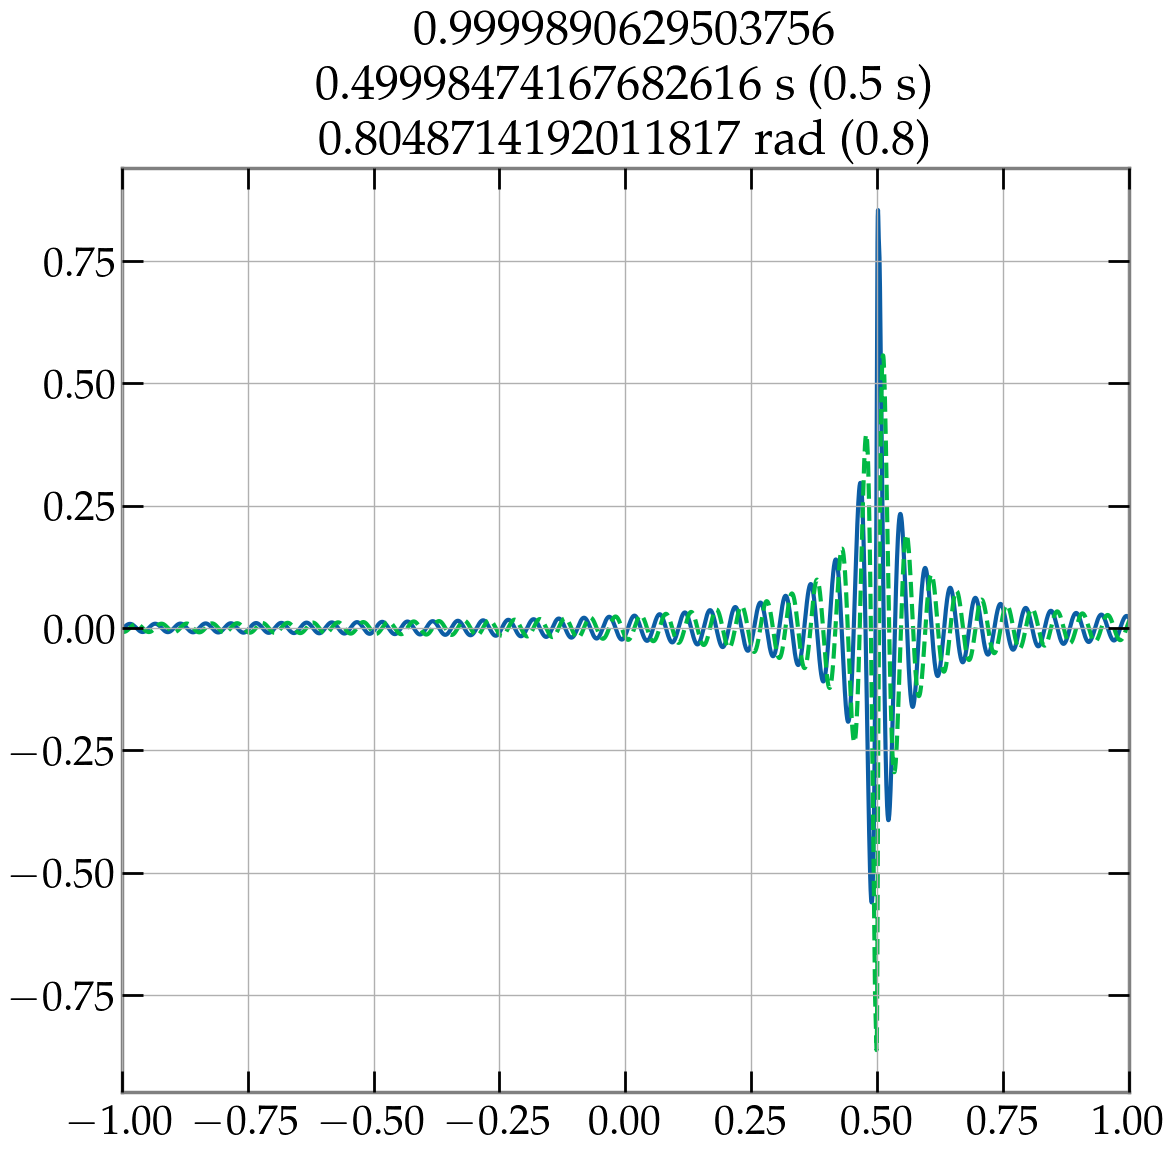

In [4]:
import numpy as np

# time_shift = 0.*u.s
# time_shift = 0.1*u.s
time_shift = 0.5*u.s
# time_shift = -0.1*u.s
# time_shift = 1.*u.s
# phase_shift = 3*np.pi*u.rad
# phase_shift = -0.5*u.rad
phase_shift = 0.8*u.rad

hp_f_fine_shifted = hp_f_fine * np.exp(2.j*np.pi*hp_f_fine.frequencies*time_shift + 1.j*phase_shift)
# hp_f_fine_shifted = hp_f_fine * np.exp(1.j*phase_shift)
# hp_f_fine_shifted = hp_f_fine * np.exp(2.j*np.pi*phase_shift)

overlap_fine, info = overlap(hp_f_fine, hp_f_fine_shifted, optimize_time_and_phase=True, return_opt_info=True)

time = info['peak_time']
phase = info['peak_phase']
# init_match_series = info['init_match_series']
match_series = info['match_series']


plt.plot(match_series.real)
plt.plot(match_series.imag, '--')

# plt.plot(init_match_series.real, '-.')
# plt.plot(init_match_series.imag, ':')

plt.xlim(-1, 1)

plt.title(f'{overlap_fine}\n{time} ({time_shift})\n{phase} ({phase_shift % (2.*np.pi)})')

plt.show()

In [5]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import TimeSeries as pycbc_timeseries
from pycbc.types import FrequencySeries as pycbc_frequencyseries

from gwpy.frequencyseries.frequencyseries import FrequencySeries

f_low, f_high = 20, 350  # f_min and some essentially arbitrary cutoff
sample_rate = 4096

# Enter some arbitrary parameters here
wfs_to_compare = {
    'signal1': {
        'mass1': 10,
        'mass2': 10,
        'spin1': 0.0,
        'spin2': 0.0
    },
    'signal2':{
        'mass1': 42,
        'mass2': 20,
        'spin1': 0.0,
        'spin2': 0.0
    }
}


hp_1_pycbc, _ = get_fd_waveform(
    approximant=approximant,
    **wfs_to_compare['signal1'],
    f_lower=f_low,
    f_upper=f_high,
    delta_f=1.0/sample_rate
)

# hp_2_pycbc, _ = get_fd_waveform(
#     approximant=approximant,
#     **wfs_to_compare['signal2'],
#     f_lower=f_low,
#     f_upper=f_high,
#     delta_f=1.0/sample_rate
# )

# hp_2_pycbc = hp_1_pycbc * np.exp(2.j*np.pi*hp_1_pycbc.sample_frequencies*time_shift.value + 1.j*phase_shift)
# hp_2_pycbc.epoch += time_shift


# tlen = max(len(hp_1_pycbc), len(hp_2_pycbc))
# hp_1_pycbc.resize(tlen)
# hp_2_pycbc.resize(tlen)
tlen = len(hp_1_pycbc)

delta_f = 1.0 / hp_1_pycbc.duration
flen = tlen//2 + 1
psd_pycbc = aLIGOZeroDetHighPower(flen, delta_f, f_low)


hp_2_pycbc = pycbc_frequencyseries(hp_1_pycbc * np.exp(2.j*np.pi*hp_1_pycbc.sample_frequencies*time_shift.value + 1.j*phase_shift),
                                #    delta_f=hp_1_pycbc.delta_f, epoch=float(hp_1_pycbc.epoch)/(2 * (tlen - 1) * delta_f) + time_shift.value)
                                   delta_f=hp_1_pycbc.delta_f, epoch=float(hp_1_pycbc.epoch) + time_shift.value*(2 * (tlen - 1) * delta_f))

hp_1_pycbc_converted = FrequencySeries.from_pycbc(hp_1_pycbc) * u.s
hp_2_pycbc_converted = FrequencySeries.from_pycbc(hp_2_pycbc) * u.s
psd_pycbc_converted = FrequencySeries.from_pycbc(psd_pycbc) / u.Hz

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [6]:
from numpy.testing import assert_allclose

overlap_pycbc, time_pycbc, phase_pycbc = match(hp_1_pycbc, hp_2_pycbc, v1_norm=1.0, v2_norm=1.0, psd=psd_pycbc, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high, return_phase=True)
# time_pycbc *= 1/(2 * (len(hp_1_pycbc) - 1) * delta_f)
# time_pycbc *= 1/(2 * (tlen - 1) * delta_f)
# time_pycbc *= hp_2_pycbc.duration / tlen
# time_pycbc *= 1/(flen * delta_f)
time_pycbc *= 1/(2 * (tlen - 1) * delta_f)**2  # Apparently we need square???

overlap_gw_signal_tools, info = inner_product(hp_1_pycbc_converted, hp_2_pycbc_converted, psd_pycbc_converted, f_range=[f_low, f_high], optimize_time_and_phase=True, return_opt_info=True)
time_gw_signal_tools = info['peak_time'].value
phase_gw_signal_tools = info['peak_phase'].value

# assert_allclose(overlap_pycbc, overlap_gw_signal_tools, atol=0.0, rtol=4e-3)
# assert_allclose(np.abs(time_pycbc), np.abs(time_gw_signal_tools), atol=0.0, rtol=3e-2)
# assert_allclose(phase_pycbc, phase_gw_signal_tools, atol=0.0, rtol=0.0)


# def test_overlap_pycbc():
#     overlap_normalized_pycbc, _ = match(hp_1_pycbc, hp_2_pycbc, psd=psd_pycbc, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high)

#     overlap_normalized_gw_signal_tools = overlap(hp_1_pycbc_converted, hp_2_pycbc_converted, psd_pycbc_converted, f_range=[f_low, f_high], optimize_time_and_phase=True)

#     assert_allclose(overlap_normalized_pycbc, overlap_normalized_gw_signal_tools, atol=0.0,rtol=2e-3)


0.8219876355399264 rad 0.8219876355399264 rad -0.0 rad


In [7]:
print(overlap_pycbc, overlap_gw_signal_tools)
# print(time_pycbc*1/(2 * (tlen - 1) * delta_f)**2, time_gw_signal_tools)
print(time_pycbc, time_gw_signal_tools)
print(phase_pycbc, phase_gw_signal_tools)

257927253.82426775 257950337.84928265
0.49993896484375 0.4999553611297456
0.7999999999999929 0.8219876355399264


To show the difference in sampling, let us look at the values

In [4]:
print(hp_f_coarse.df, hp_f_fine.df)

0.5839749073282008 Hz 0.0625 Hz


This is almost one order of magnitude difference

In [5]:
# df_test = hp_f_coarse.df / 2  # Without 1/2 assertion error
# df_test = 0.125  # Testing of df parameter
# df_test = 0.125 * u.Hz  # Testing of df parameter -> results not even too bad
# df_test = 0.001  # Error for all three calls
# df_test = 2**-10  # Smaller number, but no error
df_test = None
# f_range_test = [f_min, 250]  # Activating makes results slightly more unequal
# f_range_test = [0, 250000]  # Testing of range parameter
f_range_test = None

print(norm(hp_t, psd_gw150914, df=df_test, f_range=f_range_test))
print(norm(hp_f_fine, psd_gw150914, df=df_test, f_range=f_range_test))
print(norm(hp_f_coarse, psd_gw150914, df=df_test, f_range=f_range_test))

33.11640489019849
33.116644193989735
32.983848712367056


In [6]:
print(norm(hp_f_fine, psd_gw150914, df=df_test, f_range=f_range_test, optimize_time_and_phase=True))


(<TimeSeries([0.80597082+0.05552092j, 0.78229763+0.16323428j,
             0.7372521 +0.26154899j, ..., 0.7372521 -0.26154899j,
             0.78229763-0.16323428j, 0.80597082-0.05552092j]
            unit=Unit(dimensionless),
            t0=<Quantity -7.99975584 s>,
            dt=<Quantity 0.00048833 s>,
            name=None,
            channel=None)>, <Quantity 33.12005225>, <Quantity -6.13820106e-12 s>)


In [7]:
print(overlap(hp_t, hp_f_coarse, psd_gw150914, optimize_time_and_phase=False))
print(overlap(hp_t, hp_f_fine, psd_gw150914, optimize_time_and_phase=False))
# No need for optimization here, signals need not be shifted

0.9997019002921359
0.9999999837741272


As we can see, sampling of input makes a notable difference because the quality of interpolation depends on that.

Nonetheless, all results are consistent and even the ones for coarser sampling are acceptable with the overlap being greater than $0.999$.


Now we look at the implementation utilizing ifft

In [8]:
overlap_series_coarse, overlap_coarse, peak_time_coarse = overlap(hp_t, hp_f_coarse, psd_gw150914, optimize_time_and_phase=True)
overlap_series_fine, overlap_fine, peak_time_fine = overlap(hp_t, hp_f_fine, psd_gw150914, optimize_time_and_phase=True)

print(overlap_coarse, overlap_fine)

0.9997006849390855 0.9999999852835303


Larger than one of course makes no sense, but this only occurs in fourth digit
-> ah, does not occur if we do not use simpson norm in normalization constant; so using optimization for all computations in norm and overlap seems to make sense
-> results actually agree *really* well when doing optimization for all

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


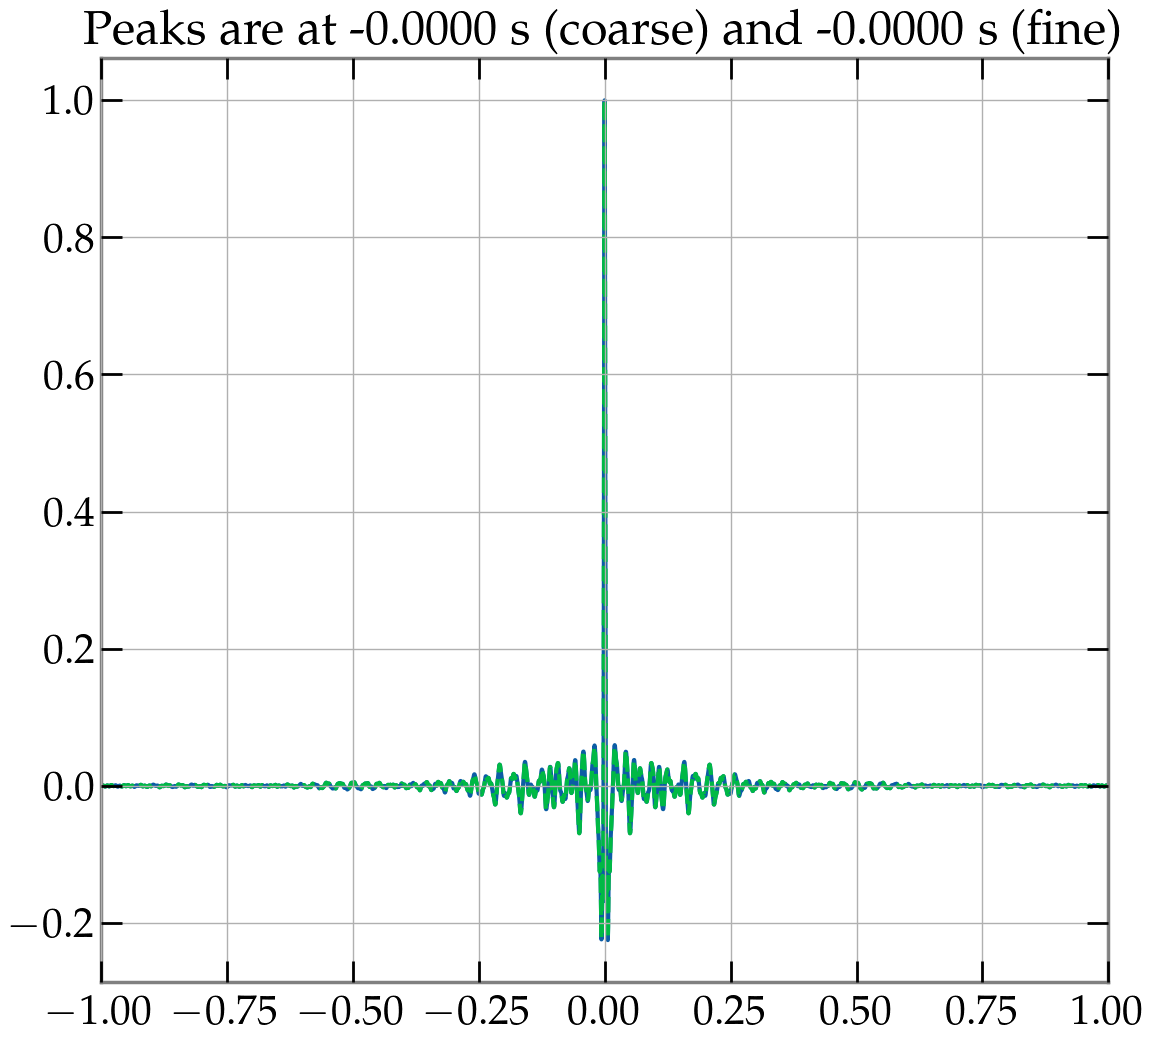

In [9]:
fig,ax = plt.subplots()

ax.plot(overlap_series_coarse)
ax.plot(overlap_series_fine, '--')

ax.set_title(f'Peaks are at {peak_time_coarse:.4f} (coarse) and {peak_time_fine:.4f} (fine)')

ax.set_xlim([-1, 1])

plt.show()

We can also demonstrate the influence of the PSD on inner product values and thus the SNR.

In [10]:
from gw_signal_tools.PSDs import psd_o3_h1, psd_o3_l1, psd_o3_v1, psd_sim

In [11]:
for psd in [psd_gw150914, psd_o3_h1, psd_o3_l1, psd_o3_v1, psd_sim]:
    print(f'SNR for {psd.name}: {norm(hp_f_fine, psd, f_range=[f_min, None])}')

SNR for PSD around GW150914: 33.116644193989735
SNR for Typical PSD of Hanford detector in O3: 53.90492875827322
SNR for Typical PSD of Livingston detector in O3: 62.77023386247954
SNR for Typical PSD of VIRGO detector in O3: 27.06448003710037
SNR for PSD values as simulated by `SimNoisePSDaLIGOZeroDetHighPower`: 91.59026595500418


## Match Testing

In [12]:
from gw_signal_tools.inner_product import optimized_inner_product
from gw_signal_tools.waveform_utils import pad_to_get_target_df, td_to_fd_waveform, fd_to_td_waveform

import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Reference value
ref_val = inner_product(hp_t, hp_t, psd_gw150914)

In [14]:
# inner_product(hp_t, hp_f_fine, psd_gw150914, optimize_time_and_phase=True)

In [15]:
test1, test2, _ = inner_product(hp_t, hp_f_fine, psd_gw150914, optimize_time_and_phase=True)

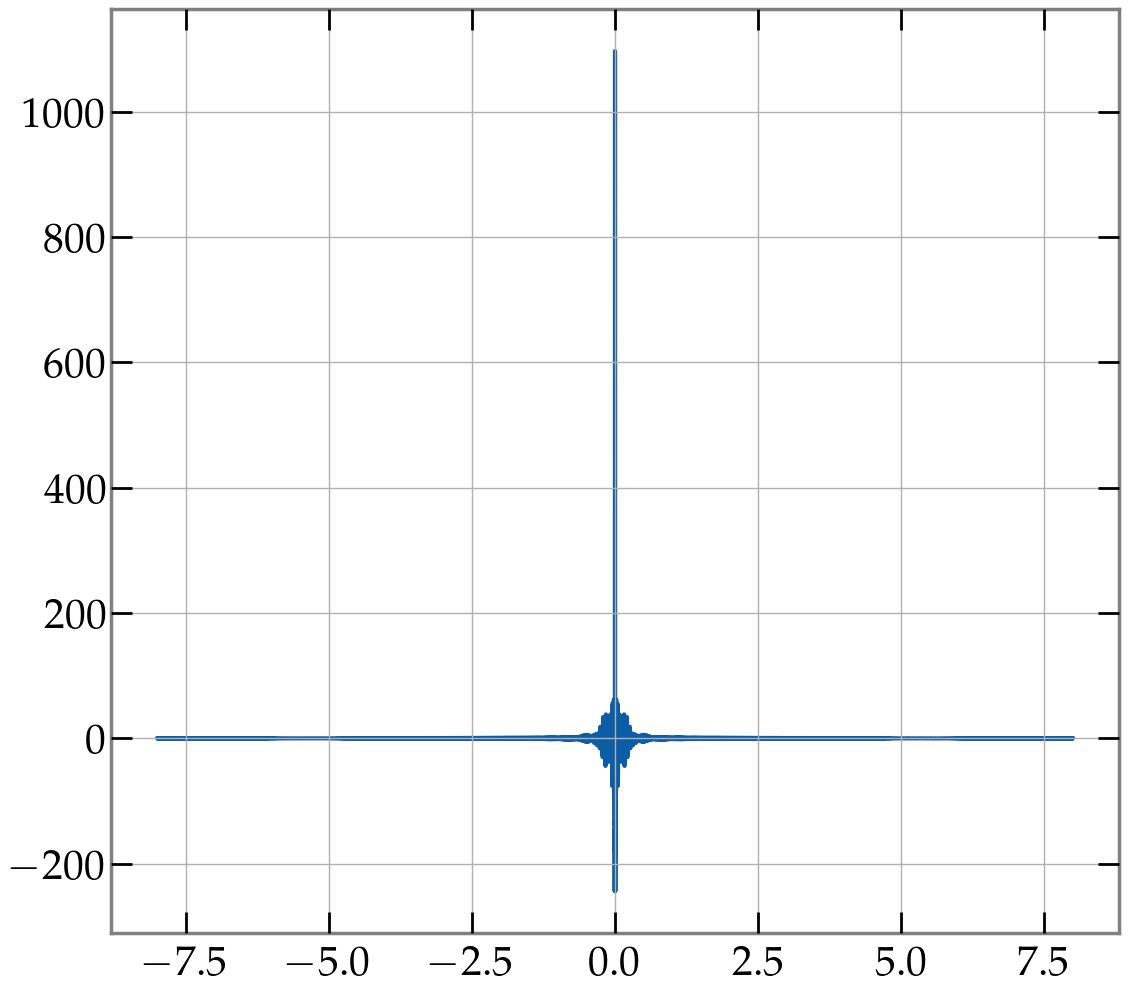

In [16]:
fig,ax = plt.subplots()

ax.plot(test1)
ax.plot(test2, '--')

# ax.set_xlim([10, 42])

plt.show()

Equal, good. As expected, conversion in inner_product works, so we can focus on what optimized_inner_product does

In [10]:
match_val, match_info = inner_product(hp_t, hp_f_fine, psd_gw150914, optimize_time_and_phase=True, return_opt_info=True)
match_series = match_info['match_series']
peak_time = match_info['peak_time']
# match_series, match_val = optimized_inner_product(*inner_product(hp_t, hp_t, psd_gw150914, optimize_time_and_phase=True))

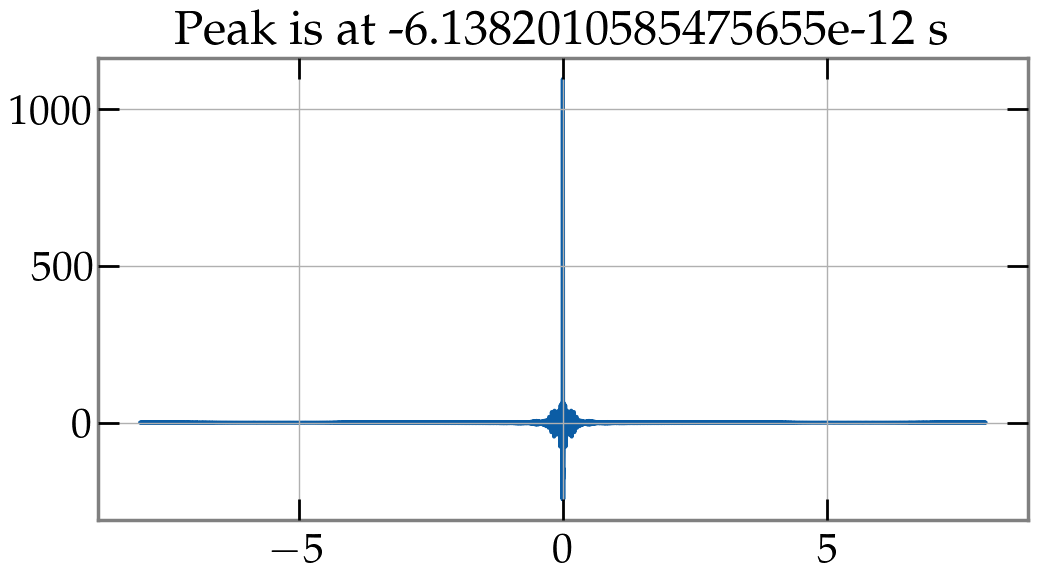

In [18]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(match_series)

ax.set_title(f'Peak is at {peak_time}')

plt.show()

In [20]:
hp_t_shifted = hp_t.copy()
hp_t_shifted.times += 2.0 * u.s
# hp_t_shifted.times -= 2.0 * u.s
# hp_t_shifted.times += 10.0 * u.s
# hp_t_shifted.times += 100.0 * u.s

# hp_t_shifted.times += pad_to_get_target_df(hp_t, df=0.0625).duration
# hp_t_shifted.times += 0.96 * pad_to_get_target_df(hp_t, df=0.0625).duration
# hp_t_shifted.times += 1.1 * pad_to_get_target_df(hp_t, df=0.0625).duration
# hp_t_shifted.times += 0.5 * pad_to_get_target_df(hp_t, df=0.0625).duration  # This one is fun

# hp_t_shifted.times += hp_t.duration
# hp_t_shifted.times += 0.96 * hp_t.duration
# hp_t_shifted.times += 1.1 * hp_t.duration
# hp_t_shifted.times += 1.5 * hp_t.duration

match_val_2, match_info_2 = inner_product(hp_t, hp_t_shifted, psd_gw150914, df=2**-8, optimize_time_and_phase=True, return_opt_info=True)
# match_val_2, match_info_2 = inner_product(hp_t_shifted, hp_t, psd_gw150914, df=2**-8, optimize_time_and_phase=True, return_opt_info=True)
match_series_2 = match_info_2['match_series']
peak_time_2 = match_info_2['peak_time']
peak_phase_2 = match_info_2['peak_phase']

Ohhh, it makes perfect sense that this overlap of frequency domain waveform and shifted time waveform is not the same. These two have different starting times!!! Therefore, the frequency domain waveforms are not equal and their overlap is not equal to their individual norm (the norms, on the other hand, are expected to be equal because the phase factors cancel)

Explanation why things get more equal as shift is increased: the oscillation in frequency domain has increased frequency (which is t0), so the sampled values have higher chance of actually coinciding with the envelope, i.e. the signal in frequency domain. This corresponds to an increasing overlap

In [20]:
print(hp_t.t0, hp_t_shifted.t0, hp_t_shifted.t0 - hp_t.t0)  # Confirmation everything has worked out

-1.615234375 s 0.384765625 s 2.0 s


In [21]:
print(ref_val, inner_product(hp_t_shifted, hp_t_shifted, psd_gw150914), match_val, match_val_2)

1096.6962728515625 1096.6962728515625 1096.929964593106 1090.869655299008


First two should be perfectly equal. Last two should be very close

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


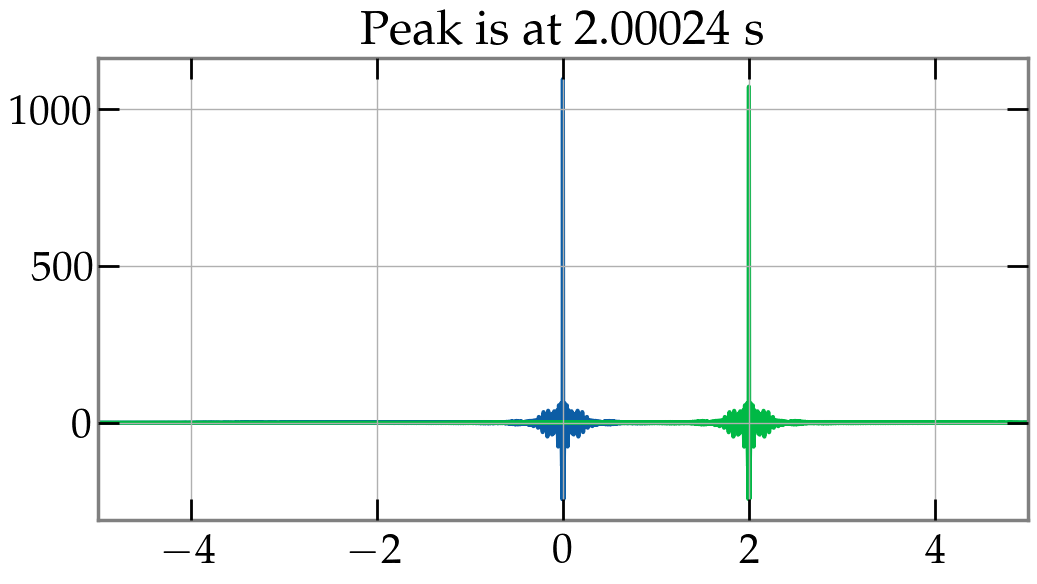

In [19]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(match_series)
ax.plot(match_series_2)

ax.set_title(f'Peak is at {peak_time_2:.5f}')

ax.set_xlim([-5, 5])
# ax.set_xlim([-2.5, -1.5])

plt.show()

Ok, nice. Peak at correct shift (see explanation below if it looks wrong at first sight). Note that we are at -2s because hp_f_shifted ahead of hp_f by 2s, but it is the second input to the inner product. The optimized inner product, however, produces time shift outputs where the shift is given from signal1 to signal2, which explains the minus sign. If we had calculated `inner_product(hp_t_shifted, hp_t, psd_gw150914, df=2**-8, optimize_time_and_phase=True)`, the peak would be at 2s.

Interesting, around the peak it looks like a sinc


Hmmm now it becomes more interesting: values are relatively equal, but they differ by factor of 2 from correct result... Is this due to different conventions with integration region?

In [23]:
print(np.sqrt(ref_val), norm(hp_t_shifted, psd_gw150914), np.sqrt(match_val), np.sqrt(match_val_v2))

33.11640489019849 33.11640489019849 33.11993304028717 33.028315962201404


Same as above, first two should be equal and last two should be close

Explanation of second peak (or single peak if only one is there):

In [24]:
print(pad_to_get_target_df(hp_t, df=hp_f_fine.df).duration, pad_to_get_target_df(hp_t_shifted, df=hp_f_fine.df).duration)
print(pad_to_get_target_df(hp_t, df=hp_f_fine.df).times[-1] - pad_to_get_target_df(hp_t_shifted, df=hp_f_fine.df).times[-1])

16.0 s 16.0 s
-2.0 s


Total length is 16s, so 14s is exactly the shift of 2s away from that. Probably has to do with the cyclic wrap-around that happens when going from FD to TD (for frequency components, shift of 2 or -2 makes no big difference).

### Tests with match of two signals

In [25]:
hp_1, _ = wfm.GenerateFDWaveform(parameters_gw150914 | {'mass1': 10 * u.solMass, 'mass2': 10 * u.solMass}, gen)
hp_2, _ = wfm.GenerateFDWaveform(parameters_gw150914 | {'mass1': 20 * u.solMass, 'mass2': 20 * u.solMass}, gen)

In [26]:
df = 2**-8

# (inner_product(hp_1, hp_2, psd_gw150914, df=df, optimize_time_and_phase=True)[1]
# / norm(hp_1, psd_gw150914, df=df)
# / norm(hp_2, psd_gw150914, df=df)
# )
overlap(hp_1, hp_2, psd_gw150914, df=df, optimize_time_and_phase=True)[1]

<Quantity 0.19575275>

## Playing around with df vs min_dt_prec

In [1]:
import astropy.units as u
from lalsimulation.gwsignal import gwsignal_get_waveform_generator
import lalsimulation.gwsignal.core.waveform as wfm

import numpy as np
from gwpy.frequencyseries import FrequencySeries

from gw_signal_tools.inner_product import inner_product, norm, overlap

/home/user/miniconda3/envs/gw_signal_tools_light/lib/python3.11/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


In [2]:
f_min = 20.*u.Hz
f_max = 1024.*u.Hz

wf_params = {
    'mass1': 36*u.solMass,
    'mass2': 29*u.solMass,
    'deltaT': 1./2048.*u.s,
    'deltaF': 2**-6*u.Hz,
    'f22_start': f_min,
    'f_max': f_max,
    'f22_ref': 20.*u.Hz,
    'phi_ref': 0.*u.rad,
    'distance': 1.*u.Mpc,
    'inclination': 0.0*u.rad,
    'eccentricity': 0.*u.dimensionless_unscaled,
    'longAscNodes': 0.*u.rad,
    'meanPerAno': 0.*u.rad,
    'condition': 0
}

approximant = 'IMRPhenomXPHM'
gen = gwsignal_get_waveform_generator(approximant)

def fd_wf_gen(wf_params):
    return wfm.GenerateFDWaveform(wf_params, gen)

hp_f_fine, _ = fd_wf_gen(wf_params)

/home/user/miniconda3/envs/gw_signal_tools_light/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


In [9]:
hf, _ = wfm.GenerateFDWaveform(wf_params | {'deltaF': 2**-2*u.Hz}, gen)

h_symm = hf  # For real fft testing

# h_symm = FrequencySeries(
#     np.flip(np.conjugate(hf)[1:]),  # Exclude zero component
#     f0=-hf.frequencies[-1],
#     df=hf.df,
#     unit=hf.unit
# ).append(hf, inplace=True)  # For complex fft testing with odd sample size
# ).append(hf[:-1], inplace=True)  # For complex fft testing with even sample size

time_shift = -0.2*u.s
phase_shift=0.12*u.rad
# Hardest combination in previous tests

# NOTE: for reference norm, we will use finely sampled waveform
norm_fine = norm(hp_f_fine)**2  # Non-optimized
# norm_fine = norm(hp_f_fine,
#     # df=2**-8,
#     # Following combination could be nicer
#     df=2**-6,
#     min_dt_prec=1e-5*u.s,
#     optimize_time_and_phase=True,
#     return_opt_info=False,
# )**2


for dt in [None, 1e-4*u.s, 1e-5*u.s, 1e-6*u.s]:
    h_symm_shifted = h_symm * np.exp(-2.j*np.pi*h_symm.frequencies*time_shift + 1.j*phase_shift)
    overlap_fine, info_fine = inner_product(
        h_symm_shifted,
        h_symm,
        optimize_time_and_phase=True,
        return_opt_info=True,
        min_dt_prec=dt,
        df=2**-2
    )
    time_fine = info_fine['peak_time']
    phase_fine = info_fine['peak_phase']
    match_series_fine = info_fine['match_series']

    print(norm_fine, overlap_fine, abs(norm_fine-overlap_fine)/norm_fine)
    print(time_fine, phase_fine, match_series_fine.dt)

6.502225118699189e-38 1 / s2 6.553004199857658e-38 1 / s2 0.007809492939953403
-0.199951171875 1 / Hz 0.13552063561749148 rad 0.000244140625 1 / Hz
6.502225118699189e-38 1 / s2 6.553689299219542e-38 1 / s2 0.007914856773007102
-0.20001220703125 1 / Hz 0.11611949411062894 rad 6.103515625e-05 1 / Hz
6.502225118699189e-38 1 / s2 6.553732126026145e-38 1 / s2 0.007921443257759831
-0.1999969482421875 1 / Hz 0.12097013189429288 rad 7.62939453125e-06 1 / Hz
6.502225118699189e-38 1 / s2 6.553734970027499e-38 1 / s2 0.007921880646700128
-0.19999980926513672 1 / Hz 0.12006063326589772 rad 9.5367431640625e-07 1 / Hz


Sweetspot: generation df of 2**-2, calculation df of 2**-2, calculation min_dt_prec of 1e-5. Has relative error below 1% (around 0.8% for norm squared, around 0.5% for norm) compared to norm of waveform that is generated at high df and then integrated using Simpson (or even IFFT method with very small df, min_dt_prec).

Interesting: calculation using full spectrum is much more accurate

Very interesting: even for a spacing of 4 (!) Hz, the correct time and phase shift are inferred to really good accuracy as long as we make min_dt_prec sufficiently small (1e-5 was typically small enough). This does increase error in integration result, i.e. overlap in this case, but otherwise a change of sampling and integration $df$ (should be the same I suppose for real test at this resolution, otherwise interpolation plays a role) has only very little effect.

In [10]:
from gw_signal_tools.inner_product import optimize_overlap

In [12]:
hf, _ = wfm.GenerateFDWaveform(wf_params, gen)

h_symm = hf  # For real fft testing

# h_symm = FrequencySeries(
#     np.flip(np.conjugate(hf)[1:]),  # Exclude zero component
#     f0=-hf.frequencies[-1],
#     df=hf.df,
#     unit=hf.unit
# ).append(hf, inplace=True)  # For complex fft testing with odd sample size
# ).append(hf[:-1], inplace=True)  # For complex fft testing with even sample size


time_shift = -0.2*u.s
phase_shift=0.12*u.rad
# Hardest combination in previous tests

def wf_gen(wf_params):
    return wfm.GenerateFDWaveform(wf_params, gen)[0]*u.s

def wf_gen_shifted(wf_params):
    wf = wfm.GenerateFDWaveform(wf_params, gen)[0]*u.s
    return wf * np.exp(-2.j*np.pi*wf.frequencies*time_shift + 1.j*phase_shift)


# for dt in [None, 1e-4*u.s, 1e-5*u.s, 1e-6*u.s]:
for dt in [1e-5*u.s]:
    wf1, wf2, info_fine = optimize_overlap(
        wf_params,
        # wf_params | {'deltaF': 2**-2*u.Hz},
        wf_gen_shifted,
        wf_gen,
        opt_params=['time', 'phase'],
        # opt_params=['time', 'psi'],
        # optimize_time_and_phase=True,
        # return_opt_info=True,
        min_dt_prec=dt,
        df=2**-2
    )
    
    print(info_fine)

2024-05-08  14:52:35  INFO (inner_product.py: 1020): Optimization was conducted successfully. Remaining  waveform mismatch is 0.00000.


{'time': <Quantity -0.19999695 1 / Hz>, 'phase': <Quantity 0.12097013 rad>}


Good, same result as above for shift of 1e-5. And using psi also works as expected

## PyCBC Comparisons

In [27]:
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

from gwpy.timeseries.timeseries import TimeSeries
from gwpy.frequencyseries.frequencyseries import FrequencySeries

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [28]:
f_low, f_high = 20, 350

sample_rate = 8192


# Enter some arbitrary parameters here
signals_to_compare = {
    'signal1': {
        'mass1': 10,
        'mass2': 10,
        'spin1': 0.6,
        'spin2': 0.0
    },
    'signal2':{
        'mass1': 96,
        'mass2': 20,
        'spin1': 0.0,
        'spin2': 0.1
    }
}


hp_1_pycbc, _ = get_fd_waveform(
    approximant=approximant,
    **signals_to_compare['signal1'],
    f_lower=f_low,
    f_upper=f_high,
    delta_f=1.0/sample_rate
)

hp_2_pycbc, _ = get_fd_waveform(
    approximant=approximant,
    **signals_to_compare['signal2'],
    f_lower=f_low,
    f_upper=f_high,
    delta_f=1.0/sample_rate
)

tlen = max(len(hp_1_pycbc), len(hp_2_pycbc))
hp_1_pycbc.resize(tlen)
hp_2_pycbc.resize(tlen)

delta_f = 1.0 / hp_2_pycbc.duration
flen = tlen//2 + 1
psd_pycbc = aLIGOZeroDetHighPower(flen, delta_f, f_low)


hp_1_pycbc_converted = FrequencySeries.from_pycbc(hp_1_pycbc) * u.s
hp_2_pycbc_converted = FrequencySeries.from_pycbc(hp_2_pycbc) * u.s
psd_pycbc_converted = FrequencySeries.from_pycbc(psd_pycbc) / u.Hz

In [29]:
overlap_normalized_pycbc, i = match(hp_1_pycbc, hp_2_pycbc, psd=psd_pycbc, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high)

print(f'The overlap is: {overlap_normalized_pycbc:.5f}')

The overlap is: 0.12560


In [30]:
overlap_series_normalized, overlap_normalized, peak_time = overlap(hp_1_pycbc_converted, hp_2_pycbc_converted, psd_pycbc_converted,
                                                                   f_range=[f_low, f_high], optimize_time_and_phase=True)

print(f'The overlap is: {overlap_normalized:.5f}')

The overlap is: 0.12536


In [31]:
print(f'The relative error is {(overlap_normalized_pycbc - overlap_normalized) / overlap_normalized_pycbc}')

The relative error is 0.0018956750540757407


/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


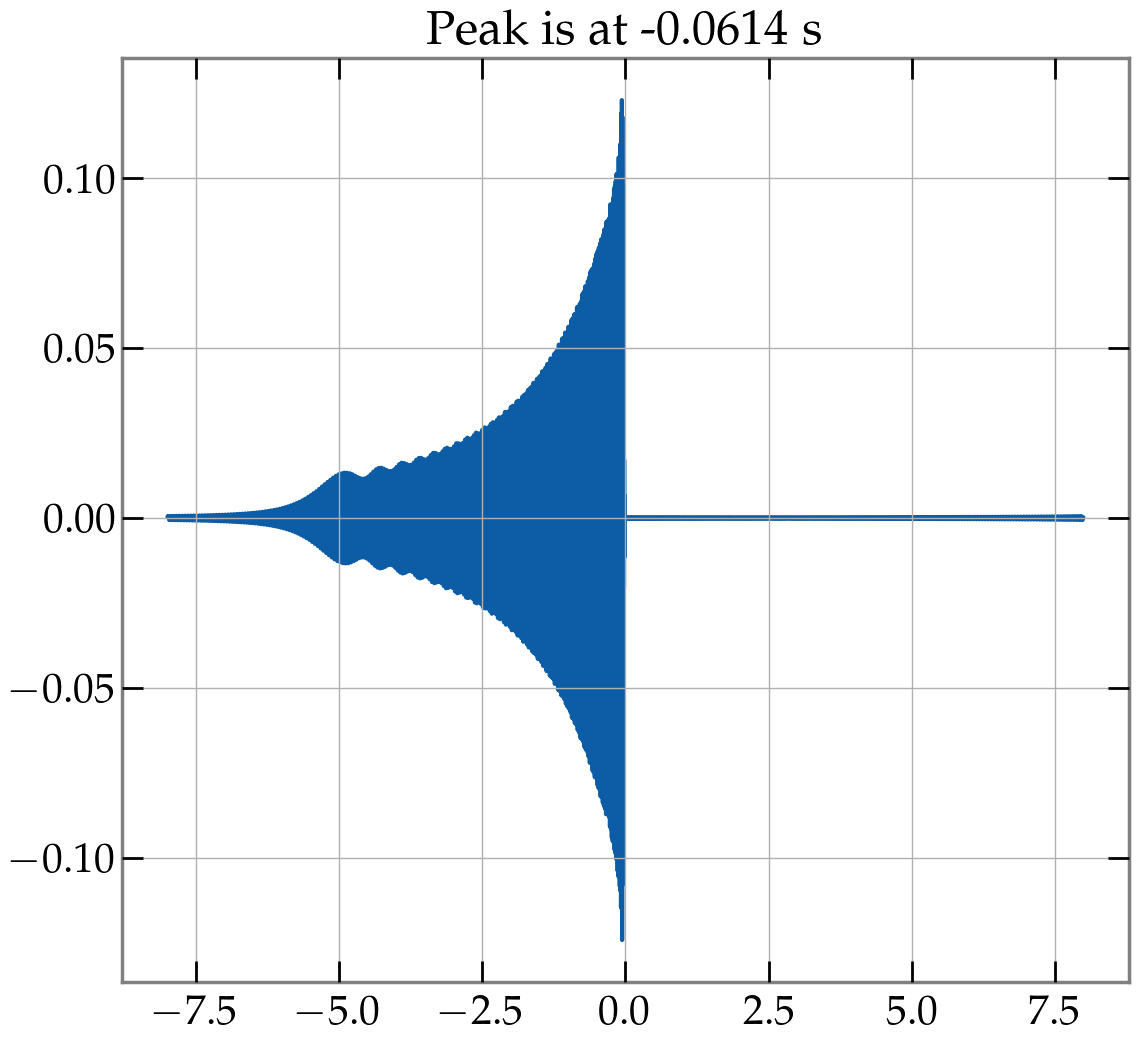

In [32]:
fig,ax = plt.subplots()

ax.plot(overlap_series_normalized)

ax.set_title(f'Peak is at {peak_time:.4f}')

plt.show()

### Other Sanity Checks

Agreement with PyCBC verified, now some other sanity checks (overlap with itself should be one, similar for shifted signal).

In [33]:
norm_series_1, norm_1, peak_time_1 = overlap(hp_1_pycbc_converted, hp_1_pycbc_converted, psd_pycbc_converted, f_range=[f_low, f_high], optimize_time_and_phase=True)
norm_series_2, norm_2, peak_time_2 = overlap(hp_2_pycbc_converted, hp_2_pycbc_converted, psd_pycbc_converted, f_range=[f_low, f_high], optimize_time_and_phase=True)

In [34]:
print(norm_1, norm_2)

1.0 1.0000000000000002


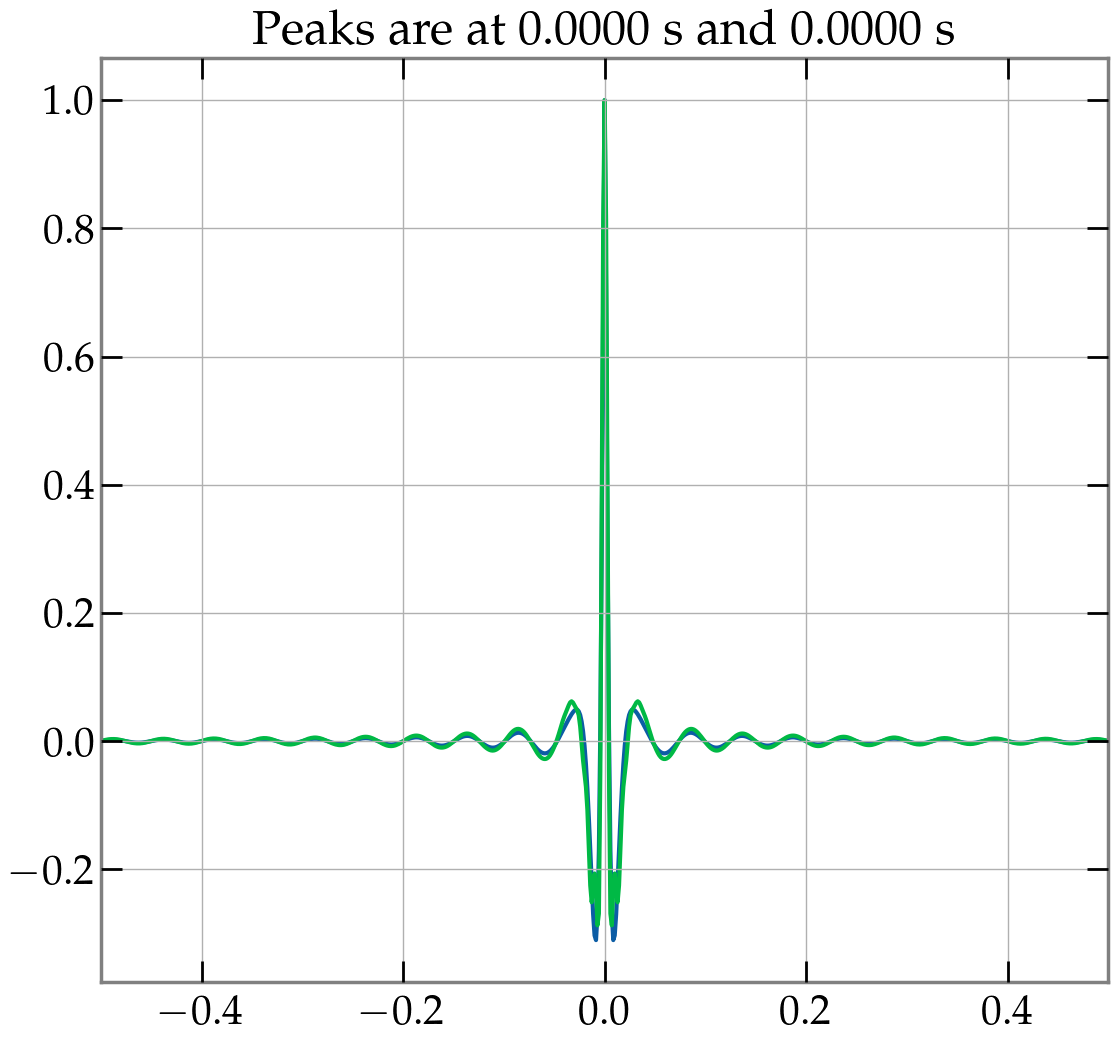

In [35]:
fig,ax = plt.subplots()

ax.plot(norm_series_1)
ax.plot(norm_series_2)

ax.set_title(f'Peaks are at {peak_time_1:.4f} and {peak_time_2:.4f}')

ax.set_xlim([-0.5, 0.5])  # Zoom onto relevant interval

plt.show()

In [36]:
hp_1_pycbc_converted_shifted = hp_1_pycbc_converted.copy()

t_shift = 2.0 * u.s

hp_1_pycbc_converted_shifted *= np.exp(1.j * 2 * np.pi * hp_1_pycbc_converted_shifted.frequencies * t_shift)

In [37]:
overlap_series_normalized, overlap_normalized, peak_time = overlap(hp_1_pycbc_converted, hp_1_pycbc_converted_shifted, psd_pycbc_converted, f_range=[f_low, f_high], optimize_time_and_phase=True)

In [38]:
print(f'The overlap is {overlap_normalized:.5f}')
print(f'The relative error is {1.0 - overlap_normalized:.5f}')

The overlap is 0.99783
The relative error is 0.00217


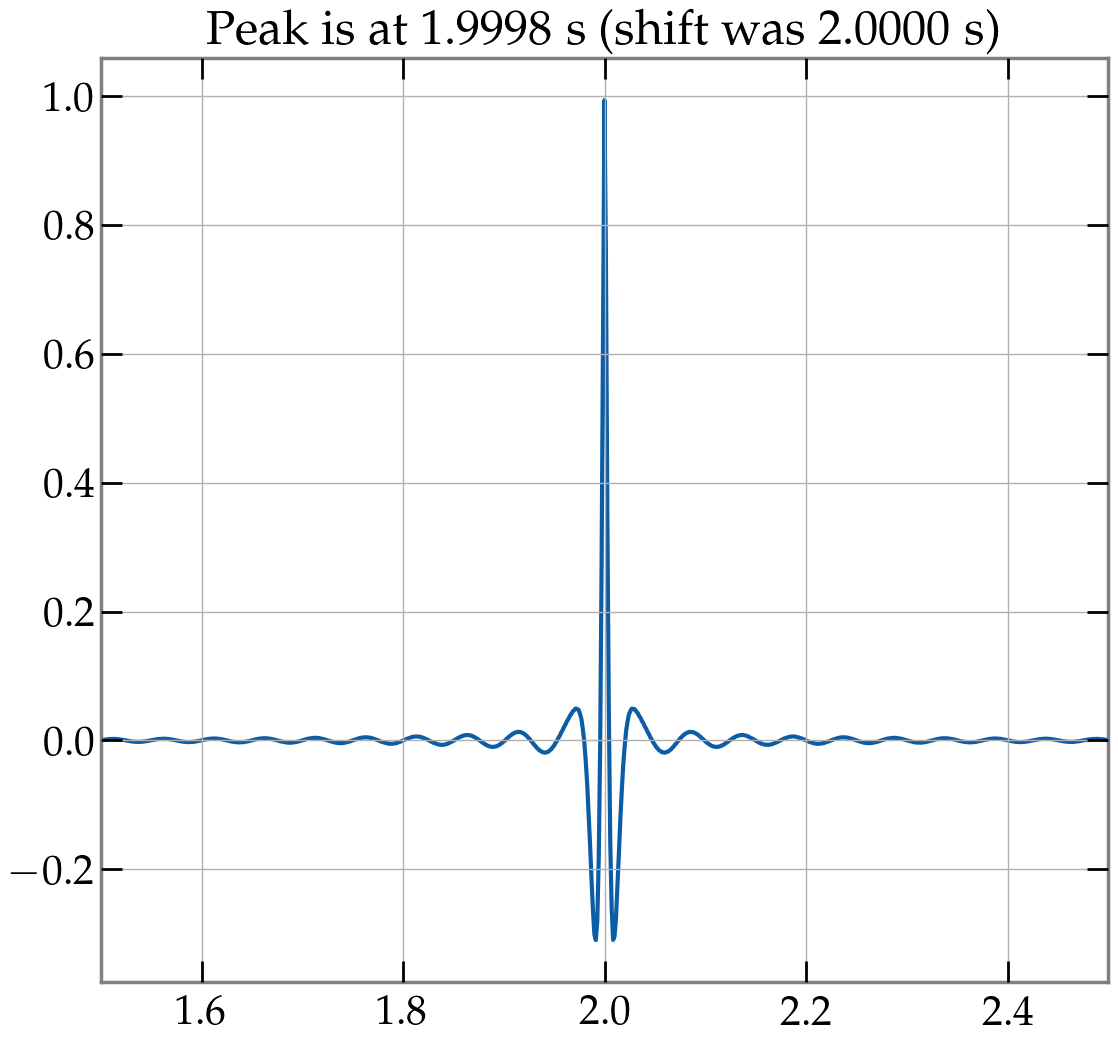

In [39]:
fig,ax = plt.subplots()

ax.plot(overlap_series_normalized)

ax.set_title(f'Peak is at {peak_time:.4f} (shift was {t_shift:.4f})')

ax.set_xlim([t_shift.value - 0.5, t_shift.value + 0.5])  # Zoom onto relevant interval

plt.show()

Question: could we have inferred a better time?

In [40]:
print(f'Difference is t_peak - t_shift = {peak_time - t_shift:.5f}, while resolution is {overlap_series_normalized.dt:.5f}')

Difference is t_peak - t_shift = -0.00018 s, while resolution is 0.00143 s


Answer: no. The difference between inferred and actual shift value are smaller than the resolution, i.e. cannot be resolved for this sample size.

## Proof that function does not change input

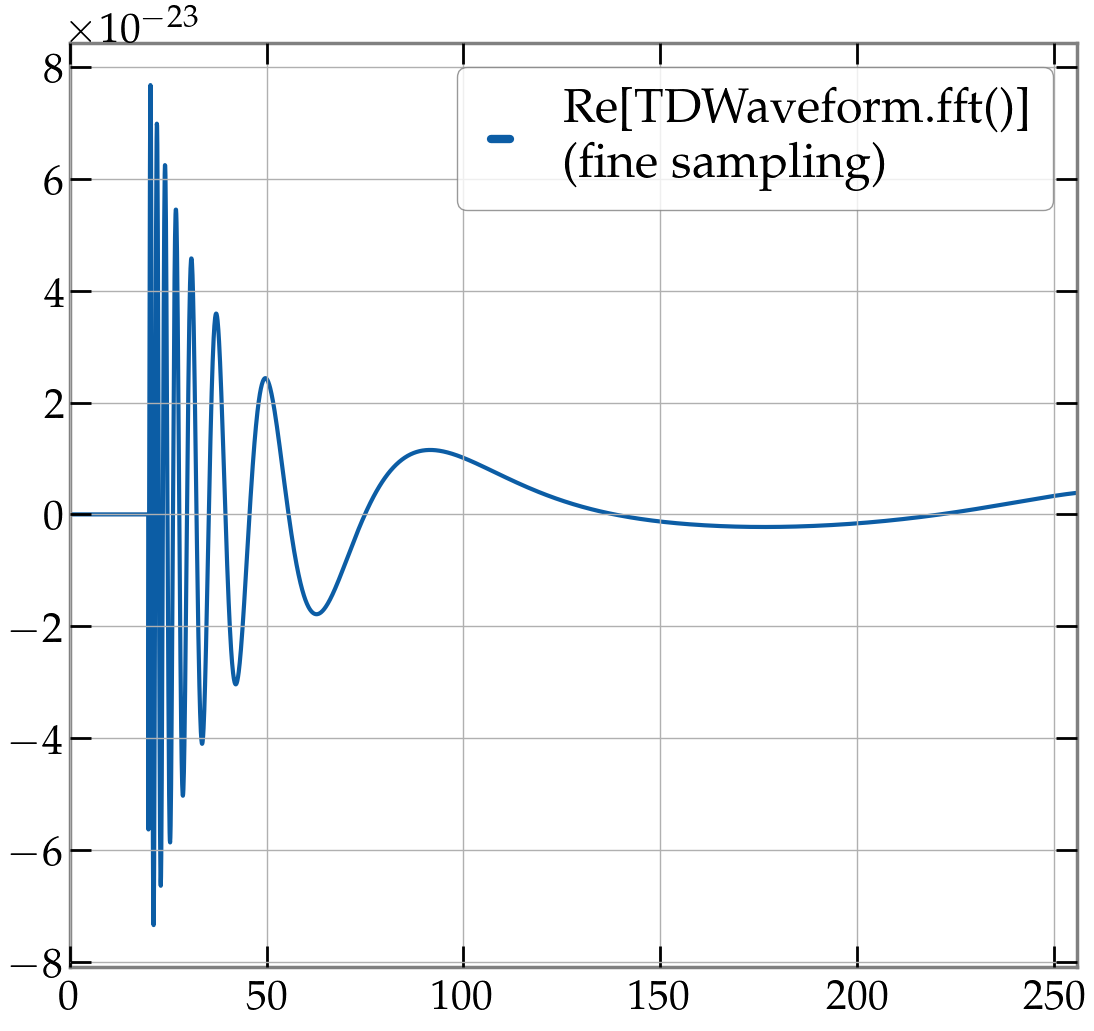

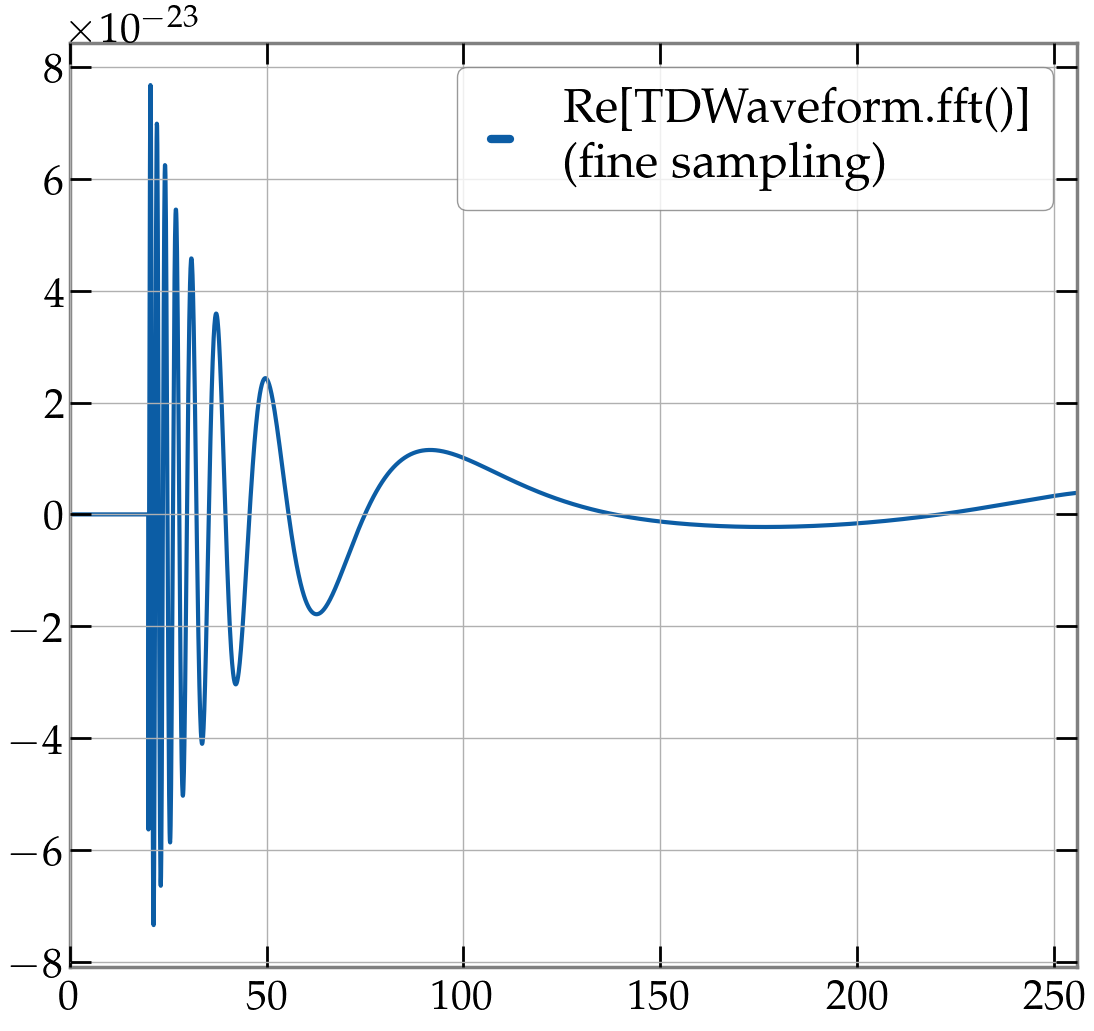

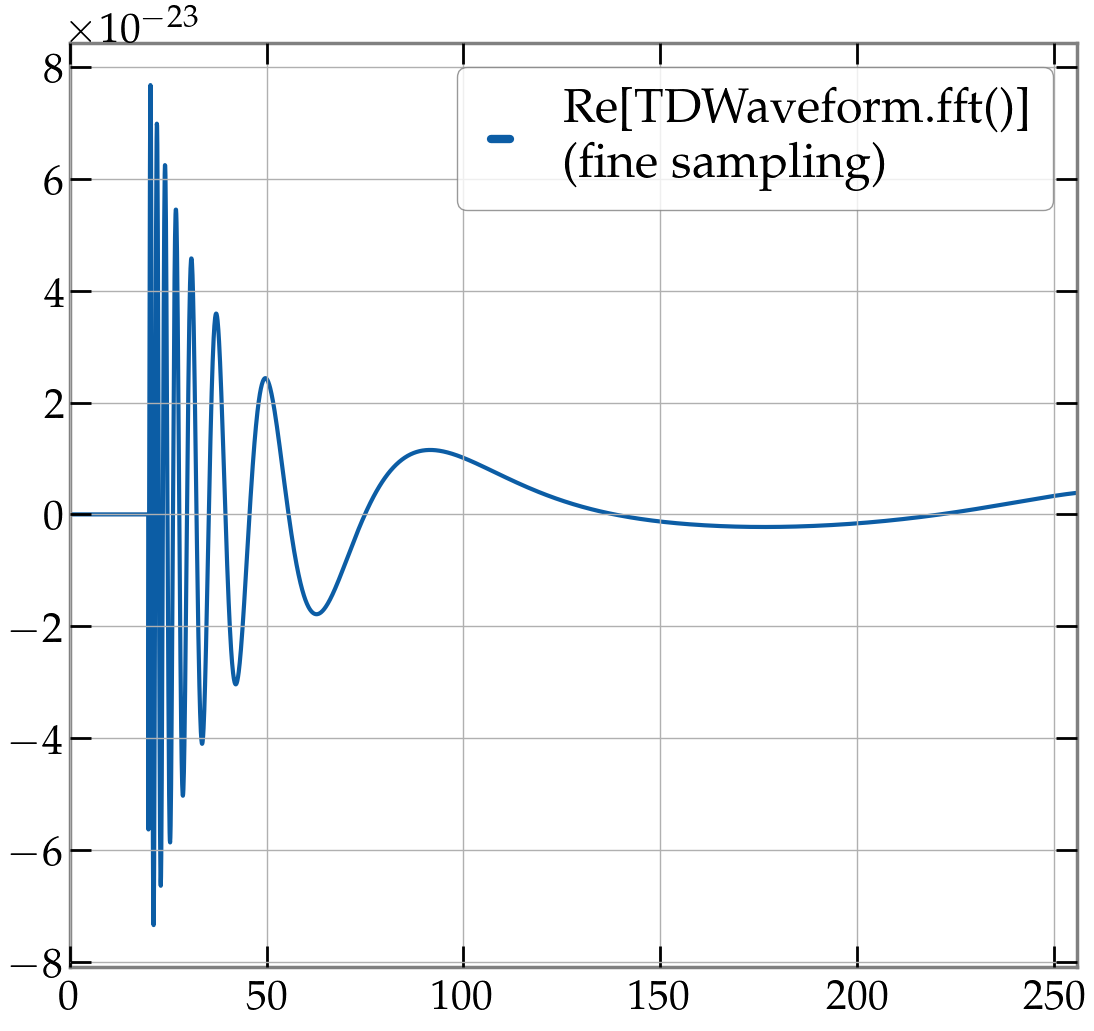

In [41]:
hp_f_fine, hc_f_fine = wfm.GenerateFDWaveform(parameters_gw150914, gen)



fig, ax = plt.subplots()

ax.plot(np.real(hp_f_fine), label='Re[TDWaveform.fft()]\n(fine sampling)')

ax.legend()

# ax.set_xlim([0.0, 42])
ax.set_xlim([0.0, 256])

plt.show()


norm(hp_f_fine, psd_gw150914, df=hp_f_fine.df, f_range=[50, 100], optimize_time_and_phase=True)


fig, ax = plt.subplots()

ax.plot(np.real(hp_f_fine), label='Re[TDWaveform.fft()]\n(fine sampling)')

ax.legend()

# ax.set_xlim([0.0, 42])
ax.set_xlim([0.0, 256])

plt.show()


norm(hp_f_fine, psd_gw150914, df=0.01, f_range=[50, 100], optimize_time_and_phase=True)


fig, ax = plt.subplots()

ax.plot(np.real(hp_f_fine), label='Re[TDWaveform.fft()]\n(fine sampling)')

ax.legend()

# ax.set_xlim([0.0, 42])
ax.set_xlim([0.0, 256])

plt.show()